# Estimate the Probability of Profit (POP) for an Option Contract
Let's consider the following scenario: Suppose we sold a `DTE = 43-day` put option on `AMD,` with a strike price of `K = 145 USD/share`, collecting the mid-point premium of `P = 5.58 USD/share` on the sale. Let's use options data and projections of the `AMD` share price to compute the contract's probability of profit (POP).

* __What is the probability of profit__? The probability of profit (POP) is the probability that at the expiration of the contract, the share price of the underlying asset $S_{T}$ is at least `0.01` USD/share _greater than_ the breakeven price of the contract. 

### Strategy to compute the POP
* __Step 1__: The strategy we'll use to compute the POP for this contract is to estimate the risk-neutral share price distribution `T`-days into the future (when the contract expires) and then construct the cumulative distribution function $F_{S}$ from that distribution.
* __Step 2__: Once we have the cumulative distribution function $F_{S}$, we use it to estimate the probability that the share price at expiration $S_{T}$ is less than or equal to some value $x$, i.e., $P(S_{T}\leq{x}) = F_{S}(x)$, or greater than some value $x$, i.e., $P(S_{T}>{x}) = 1 - F_{S}(x)$.

Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [4]:
include("Include.jl");

## Prerequisites
Before doing anything else, let's set values for our test `put` option, and build a contract model.

In [6]:
DTE = 43.0; # days to expiration
Sₒ = 148.82; # AMD underlying share price USD/share
IV = 38.11; # implied volatility
Δt = (1/365); # Time step 1-trading day
K = 145.0; # strike price for put contract
P = 5.58; # midpoint premium
B = 139.42; # observed midpoint price for put contract
POP = 0.6825; # probability of profit for short put
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 366; # 6-points per day
Δ_observed_short_put = 0.3818;

Next, we construct contract models for the options in this example. We begin by building an instance of the [MyAmericanPutContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the [custom build(...) method for this type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}).

We save the put option contract model in the `put_option_model` variable:

In [8]:
put_option_model = build(MyAmericanPutContractModel, (
    K = K, 
    premium = P, # mark price
    DTE = (DTE)*Δt,
    sense = 1, # compute greeks of long contract
    copy = 1,
    IV = (IV/100)
)); # c

## Step 1: Estimate the future share price of the underlying asset
In this task, we'll use geometric Brownian motion to compute the distribution of future share prices at expiration $S(T)$ of the put contract. Despite a few shortcomings, a nice feature of Geometric Brownian motion is that it has a convenient analytical solution:
$$
\begin{equation*}
S(t) = S_{\circ}\cdot\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\cdot\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})\cdot{Z(0,1)}\Biggr]
\end{equation*}
$$
where $S_{\circ}$ is the initial share price at $t_{\circ}$, and $Z(0,1)$ is a standard normal random variable. Geometric Brownian motion will produce a future share price distribution that follows a Log Normal distribution, with expectation and variance of the form:
$$
\begin{eqnarray*}
\mathbb{E}\left(S_{t}\right) &=& S_{o}\cdot{e}^{\mu\cdot\Delta{t}}\\
\text{Var}\left(S_{t}\right) &=& S_{\circ}^{2}e^{2\mu\cdot\Delta{t}}\left[e^{\sigma^{2}{\Delta{t}}} - 1\right]
\end{eqnarray*}
$$
where $\Delta{t} = t - t_{\circ}$. We'll use the analytical solution to compute the distribution of share price values at $t = T$, i.e., at the contract's expiration.

#### Implementation
Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 
* We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data.

In [11]:
model = build(MyGeometricBrownianMotionEquityModel, (
    μ = risk_free_rate,
    σ = (IV/100)
));

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `AMD` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop-time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

In [13]:
endpoint = let
    number_of_samples = 10000;
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

#### Check: Are future GBM share prices log-normally distributed?
We expect geometric Brownian motion to generate log-normally distributed share prices. However, we can check this expectation by performing an [exact one-sample Kolmogorov-Smirnov-test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#Kolmogorov-Smirnov-test) on the samples and a [LogNormal distribution estimated using maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). 
* The `H0:null-hypothesis` is the data (endpoint samples generated using geometric Brownian motion) comes from the LogNormal distribution `d.` The alternative hypothesis `H1:alternative`is the samples are not drawn from the distribution `d`.

Let's start this check by fitting a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [15]:
d_gbm = fit_mle(LogNormal, endpoint);

Next, execute [the exact one-sample Kolmogorov–Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.ExactOneSampleKSTest) and check the [pvalue](https://en.wikipedia.org/wiki/P-value) using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). We reject the `H0:null-hypothesis`, i.e., the `endpoint` samples are not drawn from `d_gbm` if the `pvalue` generated by the test is _less than_ some confidence cutoff, e.g.,`99%` or `0.01.`

In [17]:
test_result = ExactOneSampleKSTest(endpoint, d_gbm)

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00804655

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.5339

Details:
    number of observations:   10000


`Unihide` the code block below to see how we plotted the future share price of `AMD` generated using a risk-neutral single asset geometric Brownian motion model parameterized using historical volatility.
* __Summary__: the geometric Brownian motion generates future share prices are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the `check` above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution produces a model that describes the simulated endpoint share prices (red line).

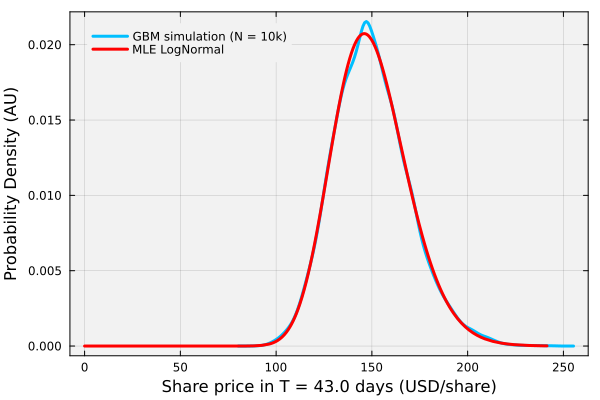

In [19]:
let
    density(endpoint, lw=3, c=:deepskyblue1, label="GBM simulation (N = 10k)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft)
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Alternative to GBM: Future share price projection using the Implied Volatility
Alternatively, we could use the implied volatility to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where mean $\mu_{IV} = S_{\circ}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{\circ}$ for short duration contracts, and standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{\circ}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). This is only an `approximate model` of the future share price; it has a couple of issues: 
* __The most significant issue__: this model assumes a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal), which is problematic because it can emit negative share prices.

However, this model is widely used to generate quick estimates of future share price ranges using the forward-looking implied volatility. Let's save the Normal IV distribution distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable:

In [21]:
d_IV = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(IV/100)*sqrt(DTE*Δt));

`Unhide` the code block below to see how we plotted the `d_gbm` and `d_IV` future share price densities at `T = 43 days.`  
* __Summary__: The log-normal gbm share price distribution (blue line) is right-skewed and cannot admit negative share prices. However, the normal IV distribution (red line) is symmetric around the initial share price $S_{\circ}$ = `148.82 USD/share.`

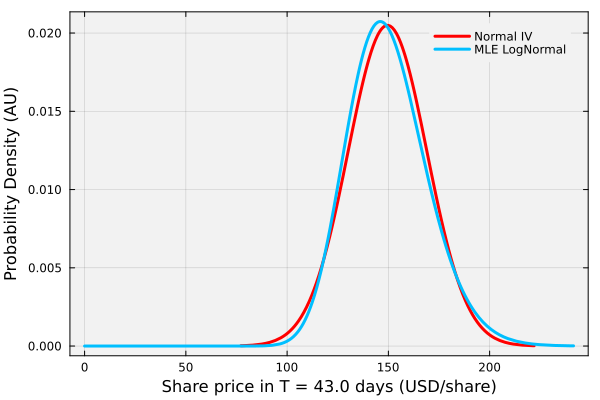

In [23]:
let
    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Next:
Now, we have two distributions describing the risk-neutral future share prices `T`-days in the future. The next step is to construct the cumulative distribution functions from these distributions.

## Step 2: Estimate the POP for the AMD put contract using the Cumulative Distribution
In this step, we'll estimate the cumulative distribution function (CDF) from the geometric Brownian motion and implied volatility share price distributions.

There are two cases that we consider when exploring the probability of profit: the buyer's and seller's perspectives:
* __Buyer's perspective__: the `AMD` share price `T` days from now $S(T)$, must be at least `0.01` USD/share _less than_ the breakeven price $B_{p}$ for the `put` contract to be profitable. Thus, the probability of profit can be calculated directly from the [cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $F_{S}(B_{p}-\epsilon) = P(S_{T}\leq{B}_{p} - \epsilon)$ where $\epsilon = $ `0.01` USD/share.
* __Seller's perspective__: the `AMD` share price `T` days from now $S(T)$, must be _greater than_ the breakeven price $B_{p}$ for the `put` contract to be profitable. Thus, the probability of profit can be calculated from the [complementary cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $P(S_{T}>{B}_{p}-\epsilon) = 1 - F_{S}(B_{p} - \epsilon)$.

We can query the cumulative distribution function $F_{S}(\star)$ using for the projected geometric Brownian motion distribution `d_gbm` and the Implied Volatility price distribution `d_IV` using the [cdf(...) function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

### Visualize CDF
`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for `AMD` share price at contract expiration using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV.` 

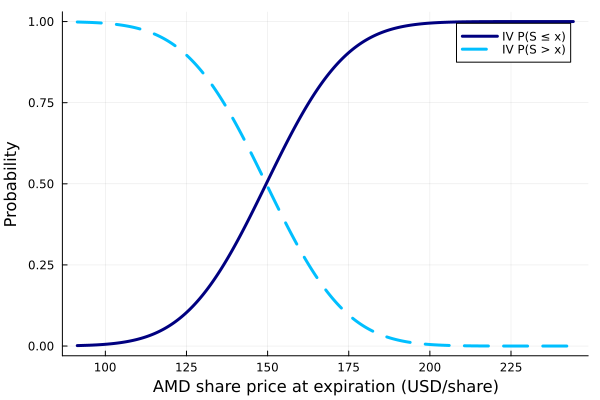

In [27]:
X = let
    number_of_samples = length(endpoint);
    X = Array{Float64,2}(undef, number_of_samples, 3);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint)
        push!(S,endpoint[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
        X[i,3] = cdf(d_IV, S[i]);
    end

    plot(X[:,1], X[:,3], lw=3, c=:navy, label="IV P(S ≤ x)")
    plot!(X[:,1], 1 .- X[:,3], lw=3, c=:deepskyblue1, ls=:dash, label="IV P(S > x)")

    xlabel!("AMD share price at expiration (USD/share)", fontsize=18);
    ylabel!("Probability", fontsize=18);
end

### Probability of profit (POP) table
`Unhide` the code block below to see how we developed a table displaying the probability of profit calculations for an `AMD` put option using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV.` 
* __Summary__: The geometric Brownian motion and implied volatility price distributions give similar results. If we compute the mean value between the two models and compare that with the observed values for both the buyer and seller, the estimated and observed POP are less than `3%` different (not shown).
* However, the best model in this case is GBM, which gives a percentage error of less than `1%`.  

In [61]:
let 
    table_df = DataFrame()
    ϵ = 0.01;

    # buyer -
    MPOP = (cdf(d_IV, B-ϵ) + cdf(d_gbm, B-ϵ))/2;
    POP_GBM = cdf(d_gbm, B-ϵ)
    POP_IV = cdf(d_IV, B-ϵ)
    buyer_row_df = (
        r = "b",
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_IV = POP_IV,
        POP_GBM = POP_GBM,
        POP_observed = 1 - POP,
        error_GBM = ((POP_GBM - (1-POP))/((1-POP)))*100,
    );
    push!(table_df, buyer_row_df)
    
    # seller -
    MPOP = ((1 - cdf(d_IV, B-ϵ)) + (1 - cdf(d_gbm, B-ϵ)))/2;
    POP_GBM = 1 - cdf(d_gbm, B-ϵ)
    POP_IV = 1 - cdf(d_IV, B-ϵ)
    seller_row_df = (
        r = "s",
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_IV = POP_IV,
        POP_GBM = POP_GBM,
        POP_observed = POP,
        error_GBM = ((POP_GBM - POP)/(POP))*100,
    );
    push!(table_df, seller_row_df)

    # make a table -
    pretty_table(table_df)
end

┌────────┬─────────┬─────────┬─────────┬──────────┬──────────┬──────────────┬───────────┐
│      r │      Sₒ │       K │       B │   POP_IV │  POP_GBM │ POP_observed │ error_GBM │
│ String │ Float64 │ Float64 │ Float64 │  Float64 │  Float64 │      Float64 │   Float64 │
├────────┼─────────┼─────────┼─────────┼──────────┼──────────┼──────────────┼───────────┤
│      b │  148.82 │   145.0 │  139.42 │ 0.300727 │ 0.314174 │       0.3175 │  -1.04741 │
│      s │  148.82 │   145.0 │  139.42 │ 0.699273 │ 0.685826 │       0.6825 │  0.487258 │
└────────┴─────────┴─────────┴─────────┴──────────┴──────────┴──────────────┴───────────┘
